# Applications of different forecasting methods on stock price data code


# A. Choose a data set of a quantity whose weekly values (e.g. closing price of a stock index every Monday) over 5 years are available. Go over this data set and make sure to clean it up of any inconsistencies, outliers, missing data, etc.

## Importing Libraries

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing
#from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
#from sklearn.model_selection import TimeSeriesSplit
#import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Getting the stock price data for APPLE

In [2]:
# Ticker symbol for company that we want to find (e.g., 'AAPL' for Apple Inc.)
ticker_symbol = 'AAPL'

# Time Period Interval
start_time = '2017-01-01'
end_time = '2021-12-31'

stock_data = yf.download(ticker_symbol, start=start_time, end=end_time)

csv_file_path = 'stock_data.csv'
stock_data.to_csv(csv_file_path)
print(f'Stock data has been saved to {csv_file_path}')

[*********************100%%**********************]  1 of 1 completed
Stock data has been saved to stock_data.csv


### Separating into weekly & Preprocessing/Cleaning

In [3]:
file_path = 'stock_data.csv'
stock_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)

weekly_data = stock_data.resample('W-FRI').agg({'Adj Close': 'last'})

# Check for missing values
cleaned_weekly_data = weekly_data.dropna()

# Drop duplicates
cleaned_weekly_data = weekly_data.drop_duplicates()

# Z-score for outlier detection
z_scores = np.abs(stats.zscore(cleaned_weekly_data['Adj Close']))
outlier_threshold = 3
outlier_indices = np.where(z_scores > outlier_threshold)
outliers = cleaned_weekly_data.iloc[outlier_indices]

print(f'Outliers:{outliers}')
print('\n')
print(cleaned_weekly_data.head())

#Saving to csv
csv_file_path = 'stock_data.csv'
cleaned_weekly_data.to_csv(csv_file_path)

# Seperate data into train and test datasets
train_train = cleaned_weekly_data[cleaned_weekly_data.index.year < 2020]
train_validation = cleaned_weekly_data[cleaned_weekly_data.index.year == 2020]
train = cleaned_weekly_data[cleaned_weekly_data.index.year < 2021]
test = cleaned_weekly_data[cleaned_weekly_data.index.year == 2021]

Outliers:Empty DataFrame
Columns: [Adj Close]
Index: []


            Adj Close
Date                 
2017-01-06  27.433193
2017-01-13  27.696096
2017-01-20  27.919458
2017-01-27  28.373146
2017-02-03  30.032022


In [4]:
cleaned_weekly_data

,Adj Close
Date,
2017-01-06,27.433193
2017-01-13,27.696096
2017-01-20,27.919458
2017-01-27,28.373146
2017-02-03,30.032022
...,...
2021-12-03,160.011719
2021-12-10,177.422821
2021-12-17,169.206696


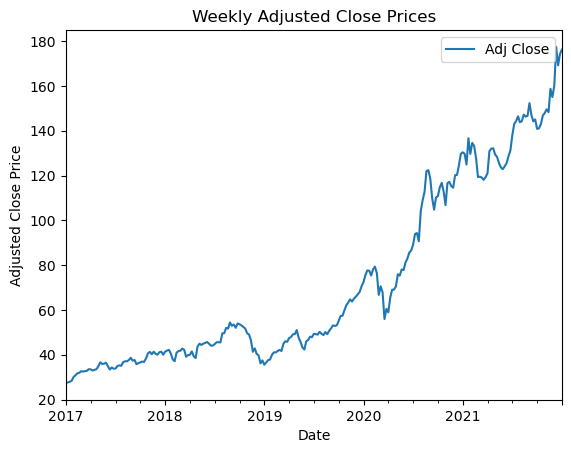

In [5]:
# Plotting the cleaned weekly data
cleaned_weekly_data.plot(title='Weekly Adjusted Close Prices')
plt.ylabel('Adjusted Close Price')
plt.show()

# B. Using the data for the first 4 years of your chosen (and cleaned up) data set, try to forecast the data of year 5. For this:

# a. Use three different forecasting techniques to perform the forecasting of level (without trend or seasonality adjustments). If a technique is parametric, try to choose the optimal value for this parameter.

# b. Compare these three techniques in two different ways.

## Naive

In [6]:
def naive(actual, periods_ahead):
    naive = np.full(len(actual) + periods_ahead, np.nan)
    
    for i in range(1, len(naive)):
        if i < len(actual): 
            naive[i] = actual[i-1]
        else:
            naive[i] = actual[-1]
    return naive

### Naive Forecast on Validation Set

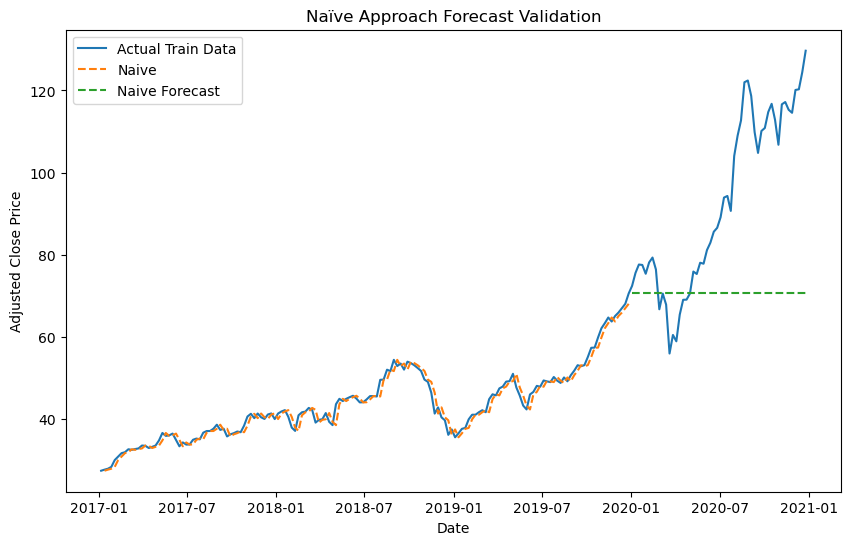

MAD: 23.93
MSE: 927.41


In [7]:
train['naive'] = naive(train_train['Adj Close'], len(train_validation))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, train['naive'][:len(train_train)], linestyle='--', label='Naive')
plt.plot(train_validation.index, train['naive'][-len(train_validation):], linestyle='--', label='Naive Forecast')
plt.title('Naïve Approach Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(train_validation['Adj Close'] - train['naive'][-len(train_validation):]))
mse = np.mean(np.square(train_validation['Adj Close'] - train['naive'][-len(train_validation):]))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

### Naive Forecast for 5th Year

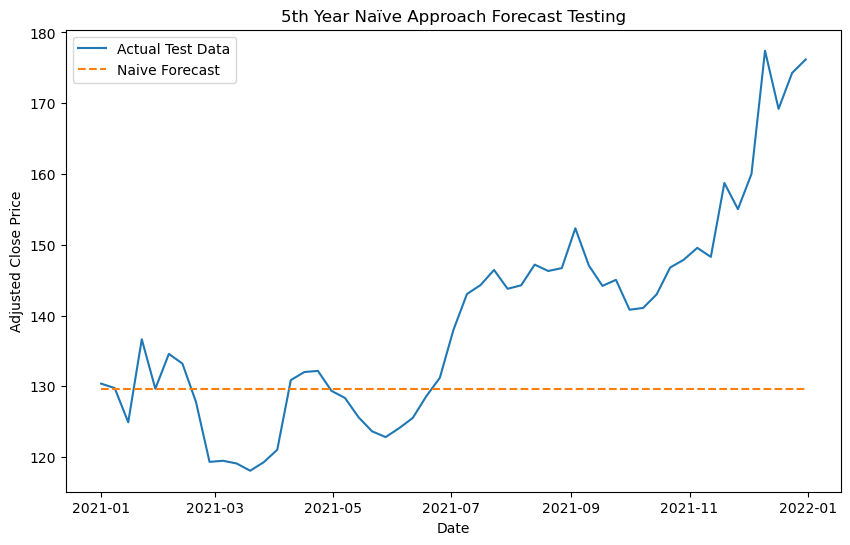

MAD: 13.16
MSE: 309.61


In [8]:
test['naive'] = naive(train['Adj Close'], len(test))[-len(test):]

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, test['naive'], linestyle='--', label='Naive Forecast')
plt.title('5th Year Naïve Approach Forecast Testing')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(test['Adj Close'] - test['naive']))
mse = np.mean(np.square(test['Adj Close'] - test['naive']))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

## Moving Average

In [9]:
def moving_avg(actual, periods_ahead, window):
    moving_avg = np.full(len(actual) + periods_ahead, np.nan)
    temp = actual
    
    for i in range(1, len(moving_avg)):
        if i < window:    
            moving_avg[i] = np.mean(temp[0:i])
            if i >= len(actual):
                temp = np.append(temp, moving_avg[i])
        else:
            moving_avg[i] = np.mean(temp[i-window:i])
            if i >= len(actual):
                temp = np.append(temp, moving_avg[i])
    return moving_avg

### Calculate best window based on Moving Average Forecast on Validation Set

In [10]:
moving_avg_window_metrics = pd.DataFrame(columns=['window', 'mad', 'mse'])

for window in range(2, len(train_train)):
    mad = np.mean(np.abs(train_validation['Adj Close'] - moving_avg(train_train['Adj Close'], len(train_validation), window)[-len(train_validation):]))
    mse = np.mean(np.square(train_validation['Adj Close'] - moving_avg(train_train['Adj Close'], len(train_validation), window)[-len(train_validation):]))
    new_row = pd.DataFrame({'window': [window], 'mad': [mad], 'mse': [mse]})
    moving_avg_window_metrics = pd.concat([moving_avg_window_metrics, new_row], ignore_index=True)

min_mad = moving_avg_window_metrics['mad'].min()
min_mad_row = moving_avg_window_metrics.loc[moving_avg_window_metrics['mad'].idxmin()]
min_mad_window = min_mad_row['window']
min_mse = moving_avg_window_metrics['mse'].min()
min_mse_row = moving_avg_window_metrics.loc[moving_avg_window_metrics['mse'].idxmin()]
min_mse_window = min_mse_row['window']

print(f'Minimum MAD ({min_mad:.2f}) achieved with window size of {min_mad_window}')
print(f'Minimum MSE ({min_mse:.2f}) achieved with window size of {min_mse_window}')

Minimum MAD (24.52) achieved with window size of 2
Minimum MSE (965.09) achieved with window size of 2


### Moving Average Forecast on Validation Set

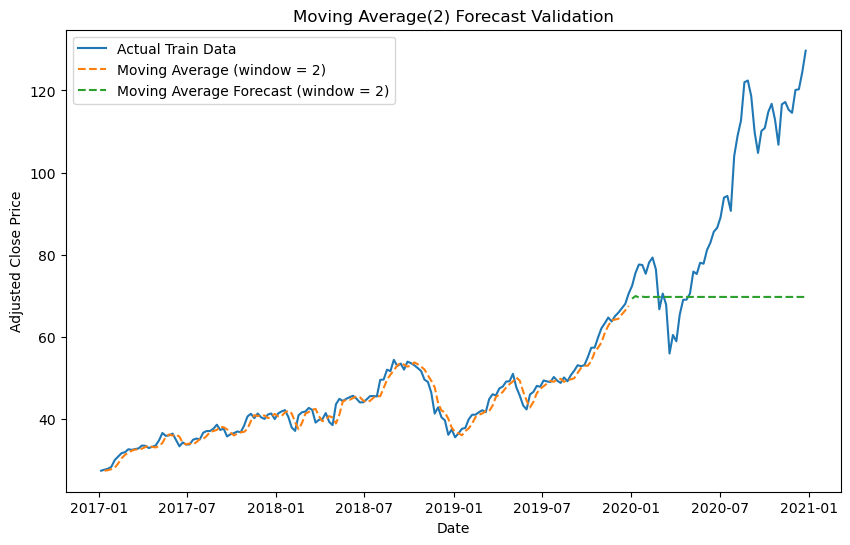

MAD: 24.52
MSE: 965.09


In [11]:
train['moving_avg(2)'] = moving_avg(train_train['Adj Close'], len(train_validation), 2)

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, train['moving_avg(2)'][:len(train_train)], linestyle='--', label='Moving Average (window = 2)')
plt.plot(train_validation.index, train['moving_avg(2)'][-len(train_validation):], linestyle='--', label='Moving Average Forecast (window = 2)')
plt.title('Moving Average(2) Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(train_validation['Adj Close'] - train['moving_avg(2)'][-len(train_validation):]))
mse = np.mean(np.square(train_validation['Adj Close'] - train['moving_avg(2)'][-len(train_validation):]))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

### Moving Average Forecast for 5th Year

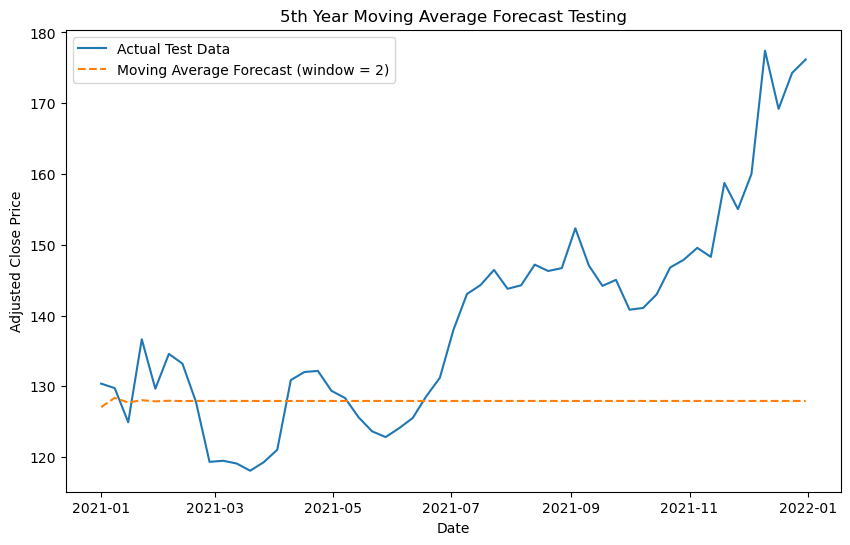

MAD: 13.94
MSE: 345.58


In [12]:
test['moving_avg(2)'] = moving_avg(train['Adj Close'], len(test), 2)[-len(test):]

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, test['moving_avg(2)'], linestyle='--', label='Moving Average Forecast (window = 2)')
plt.title('5th Year Moving Average Forecast Testing')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(test['Adj Close'] - test['moving_avg(2)']))
mse = np.mean(np.square(test['Adj Close'] - test['moving_avg(2)']))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

## Simple Exponential Smoothing

In [13]:
def exp_smooth(actual, periods_ahead, a):
    exp_smooth = np.full(len(actual) + periods_ahead, np.nan)
    exp_smooth[0] = actual[0]
    temp = actual
    
    for i in range(1, len(exp_smooth)):
        exp_smooth[i] = a * temp[i-1] + (1 - a) * exp_smooth[i-1]
        if i >= len(actual):
            temp = np.append(temp, exp_smooth[i])
    return exp_smooth

### Calculate best a based on Simple Exponential Smoothing Forecast on Validation Set

In [14]:
exp_smooth_a_metrics = pd.DataFrame(columns=['a', 'mad', 'mse'])

for a in np.arange(0.01, 1, 0.01):
    mad = np.mean(np.abs(train_validation['Adj Close'] - exp_smooth(train_train['Adj Close'], len(train_validation), a)[-len(train_validation):]))
    mse = np.mean(np.square(train_validation['Adj Close'] - exp_smooth(train_train['Adj Close'], len(train_validation), a)[-len(train_validation):]))
    new_row = pd.DataFrame({'a': [a], 'mad': [mad], 'mse': [mse]})
    exp_smooth_a_metrics = pd.concat([exp_smooth_a_metrics, new_row], ignore_index=True)

min_mad = exp_smooth_a_metrics['mad'].min()
min_mad_row = exp_smooth_a_metrics.loc[exp_smooth_a_metrics['mad'].idxmin()]
min_mad_a = min_mad_row['a']
min_mse = exp_smooth_a_metrics['mse'].min()
min_mse_row = exp_smooth_a_metrics.loc[exp_smooth_a_metrics['mse'].idxmin()]
min_mse_a = min_mse_row['a']

print(f'Minimum MAD ({min_mad:.2f}) achieved with a = {min_mad_a}')
print(f'Minimum MSE ({min_mse:.2f}) achieved with a = {min_mse_a}')

Minimum MAD (23.95) achieved with a = 0.99
Minimum MSE (928.53) achieved with a = 0.99


### Simple Exponential Smoothing Forecast on Validation Set

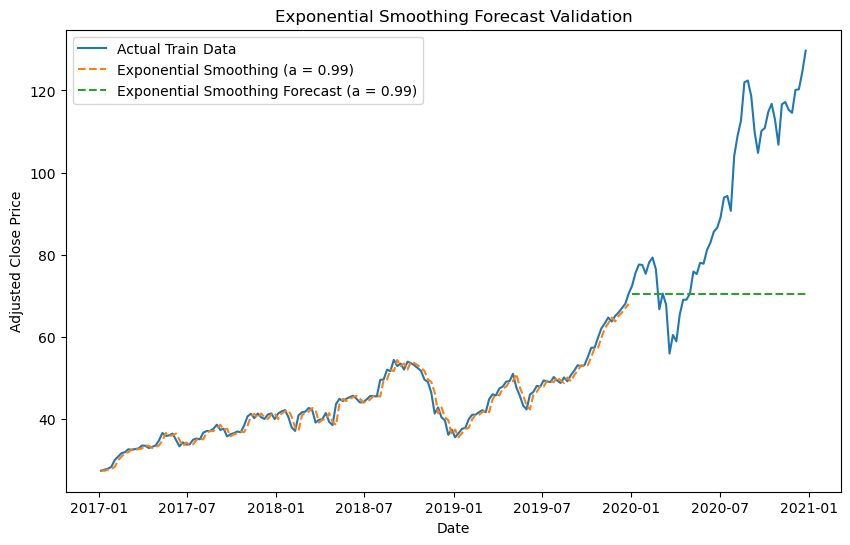

MAD: 23.95
MSE: 928.53


In [15]:
train['exp_smooth(0.99)'] = exp_smooth(train_train['Adj Close'], len(train_validation), 0.99)

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, train['exp_smooth(0.99)'][:len(train_train)], linestyle='--', label='Exponential Smoothing (a = 0.99)')
plt.plot(train_validation.index, train['exp_smooth(0.99)'][-len(train_validation):], linestyle='--', label='Exponential Smoothing Forecast (a = 0.99)')
plt.title('Exponential Smoothing Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(train_validation['Adj Close'] - train['exp_smooth(0.99)'][-len(train_validation):]))
mse = np.mean(np.square(train_validation['Adj Close'] - train['exp_smooth(0.99)'][-len(train_validation):]))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

### Simple Exponential Smoothing Forecast for 5th Year

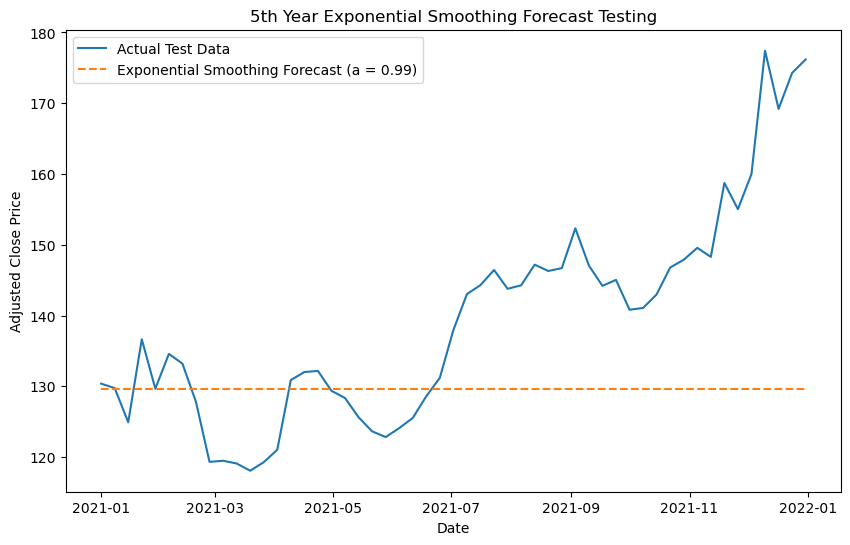

MAD: 13.18
MSE: 310.61


In [16]:
test['exp_smooth(0.99)'] = exp_smooth(train['Adj Close'], len(test), 0.99)[-len(test):]

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, test['exp_smooth(0.99)'], linestyle='--', label='Exponential Smoothing Forecast (a = 0.99)')
plt.title('5th Year Exponential Smoothing Forecast Testing')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(test['Adj Close'] - test['exp_smooth(0.99)']))
mse = np.mean(np.square(test['Adj Close'] - test['exp_smooth(0.99)']))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

# c. Try to see if there is a trend on the first 4 years' data set, estimate it and then do a trend-adjusted forecasting for year 5.

### Calculate best a and b combination based on Exponential Smoothing Forecast on Validation Set

### (Takes a few minutes to compute)

In [17]:
model = ExponentialSmoothing(train_train['Adj Close'], trend='add')
exp_smooth_trend_metrics = pd.DataFrame(columns=['a', 'b', 'mad', 'mse'])

for a in np.arange(0.01, 1, 0.01):
    for b in np.arange(0.01, 1, 0.01):
        result = model.fit(smoothing_level=a, smoothing_trend=b)
        forecast = result.forecast(len(train_validation))
        mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
        mse = np.mean(np.square(train_validation['Adj Close'] - forecast))
        new_row = pd.DataFrame({'a': [a], 'b': [b], 'mad': [mad], 'mse': [mse]})
        exp_smooth_trend_metrics = pd.concat([exp_smooth_trend_metrics, new_row], ignore_index=True)

min_mad = exp_smooth_trend_metrics['mad'].min()
min_mad_row = exp_smooth_trend_metrics.loc[exp_smooth_trend_metrics['mad'].idxmin()]
min_mad_a = min_mad_row['a']
min_mad_b = min_mad_row['b']
min_mse = exp_smooth_trend_metrics['mse'].min()
min_mse_row = exp_smooth_trend_metrics.loc[exp_smooth_trend_metrics['mse'].idxmin()]
min_mse_a = min_mse_row['a']
min_mse_b = min_mse_row['b']

print(f'Minimum MAD ({min_mad:.2f}) achieved with a = {min_mad_a} and b = {min_mad_b}')
print(f'Minimum MSE ({min_mse:.2f}) achieved with a = {min_mse_a} and b = {min_mse_b}')

Minimum MAD (7.48) achieved with a = 0.01 and b = 0.53
Minimum MSE (86.68) achieved with a = 0.03 and b = 0.77


### Trend Adjusted Exponential Smoothing Forecast on Validation Set

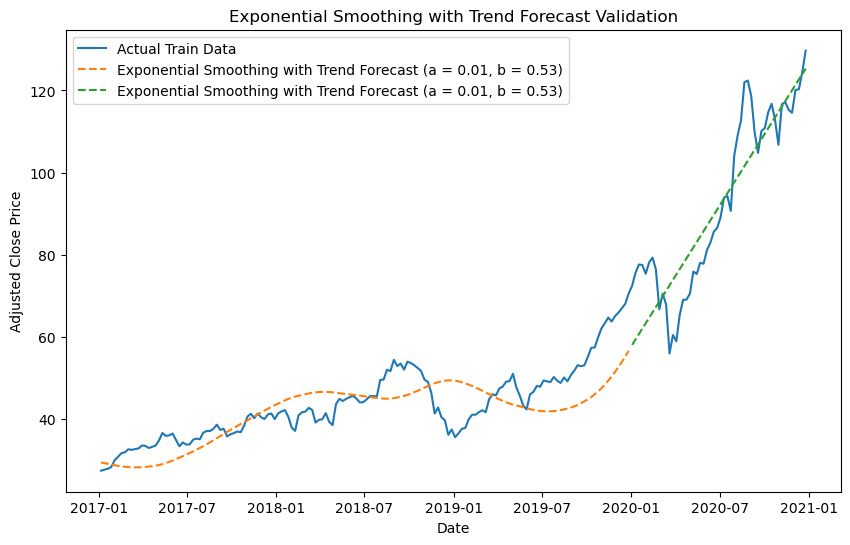

MAD: 7.48
MSE: 87.81


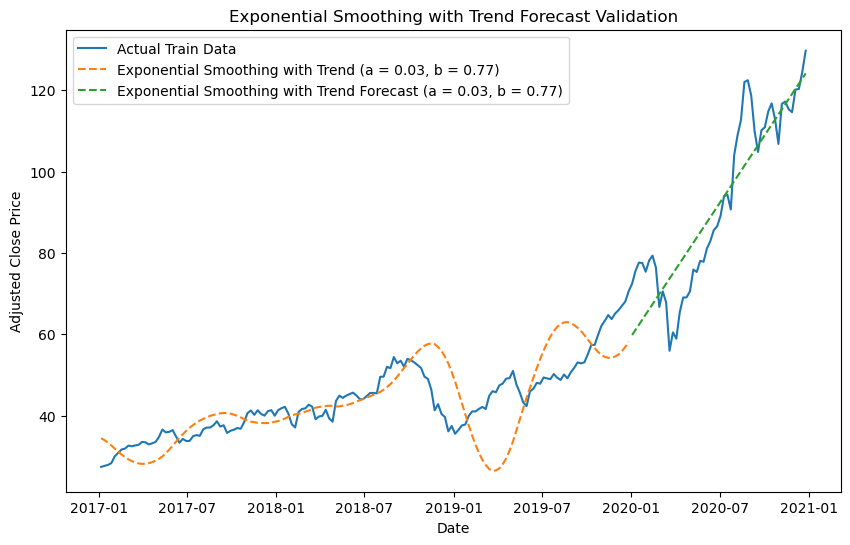

MAD: 7.52
MSE: 86.68


In [18]:
model = ExponentialSmoothing(train_train['Adj Close'], trend='add')
result = model.fit(smoothing_level=0.01, smoothing_trend=0.53)
forecast = result.forecast(len(train_validation))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, result.fittedvalues, linestyle='--', label='Exponential Smoothing with Trend Forecast (a = 0.01, b = 0.53)')
plt.plot(train_validation.index, forecast, linestyle='--', label='Exponential Smoothing with Trend Forecast (a = 0.01, b = 0.53)')
plt.title('Exponential Smoothing with Trend Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
mse = np.mean(np.square(train_validation['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

result = model.fit(smoothing_level=0.03, smoothing_trend=0.77)
forecast = result.forecast(len(train_validation))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, result.fittedvalues, linestyle='--', label='Exponential Smoothing with Trend (a = 0.03, b = 0.77)')
plt.plot(train_validation.index, forecast, linestyle='--', label='Exponential Smoothing with Trend Forecast (a = 0.03, b = 0.77)')
plt.title('Exponential Smoothing with Trend Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
mse = np.mean(np.square(train_validation['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

### Trend Adjusted Exponential Smoothing Forecast for 5th Year

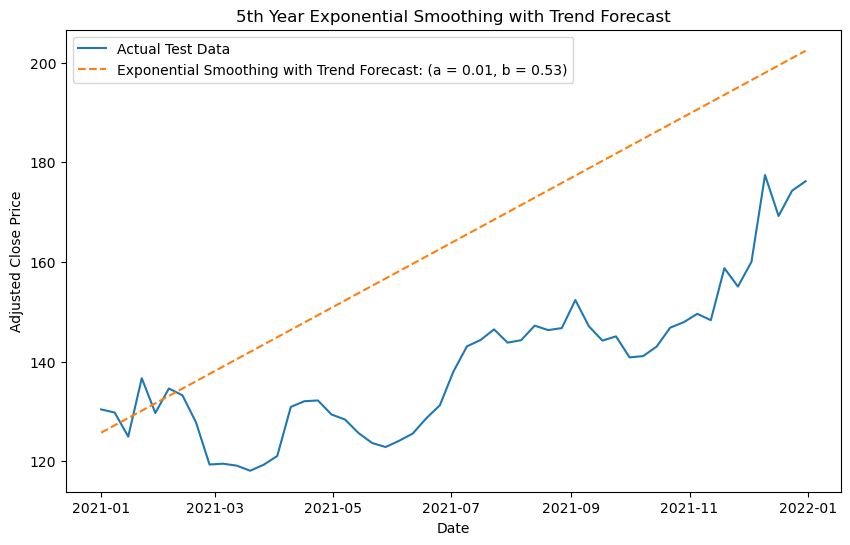

MAD: 25.47
MSE: 786.85


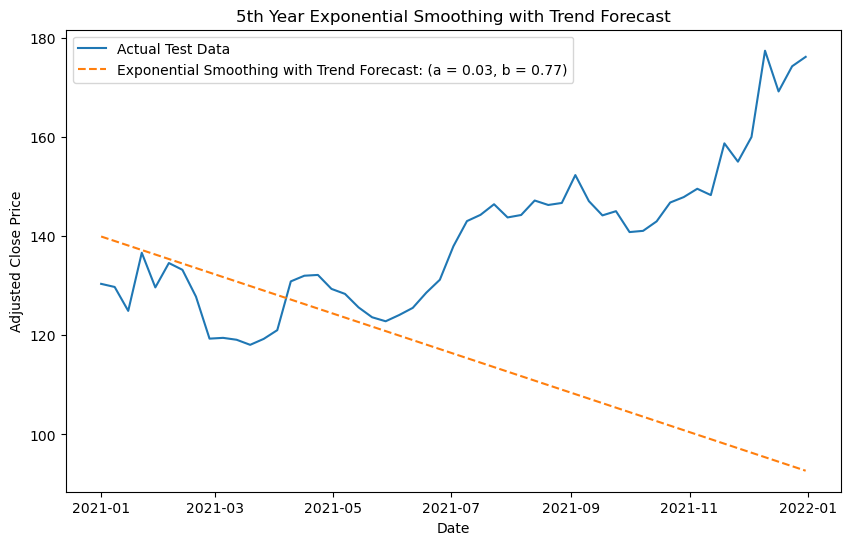

MAD: 27.10
MSE: 1280.72


In [19]:
model = ExponentialSmoothing(train['Adj Close'], trend='add')
result = model.fit(smoothing_level=0.01, smoothing_trend=0.53)
forecast = result.forecast(len(test))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, forecast, linestyle='--', label='Exponential Smoothing with Trend Forecast: (a = 0.01, b = 0.53)')
plt.title('5th Year Exponential Smoothing with Trend Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(test['Adj Close'] - forecast))
mse = np.mean(np.square(test['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

result = model.fit(smoothing_level=0.03, smoothing_trend=0.77)
forecast = result.forecast(len(test))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, forecast, linestyle='--', label='Exponential Smoothing with Trend Forecast: (a = 0.03, b = 0.77)')
plt.title('5th Year Exponential Smoothing with Trend Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(test['Adj Close'] - forecast))
mse = np.mean(np.square(test['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

# d. Then try to see if there is seasonality in the first 4 years' data, estimate the seasonality factor and then adjust your forecasting for seasonality as well.

### Calculate best a, b and g combination based on Exponential Smoothing Forecast on Validation Set

### (Commented out because it takes hours to compute)

In [20]:
#model = ExponentialSmoothing(train_train['Adj Close'], trend='add', seasonal='add', seasonal_periods=52)
#exp_smooth_season_metrics = pd.DataFrame(columns=['a', 'b', 'g', 'mad', 'mse'])
#
#for a in np.arange(0.01, 1, 0.01):
#    for b in np.arange(0.01, 1, 0.01):
#        for g in np.arange(0.01, 1, 0.01):
#            result = model.fit(smoothing_level=a, smoothing_trend=b, smoothing_seasonal=g)
#            forecast = result.forecast(len(train_validation))
#            mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
#            mse = np.mean(np.square(train_validation['Adj Close'] - forecast))
#            new_row = pd.DataFrame({'a': [a], 'b': [b], 'g': [g], 'mad': [mad], 'mse': [mse]})
#            exp_smooth_season_metrics = pd.concat([exp_smooth_season_metrics, new_row], ignore_index=True)
#
#min_mad = exp_smooth_trend_metrics['mad'].min()
#min_mad_row = exp_smooth_season_metrics.loc[exp_smooth_season_metrics['mad'].idxmin()]
#min_mad_a = min_mad_row['a']
#min_mad_b = min_mad_row['b']
#min_mad_g = min_mad_row['g']
#min_mse = exp_smooth_trend_metrics['mse'].min()
#min_mse_row = exp_smooth_season_metrics.loc[exp_smooth_season_metrics['mse'].idxmin()]
#min_mse_a = min_mse_row['a']
#min_mse_b = min_mse_row['b']
#min_mse_g = min_mse_row['g']
#
#print(f'Minimum MAD ({min_mad:.2f}) achieved with a = {min_mad_a} and b = {min_mad_b} and g = {min_mad_g}')
#print(f'Minimum MSE ({min_mse:.2f}) achieved with a = {min_mse_a} and b = {min_mse_b} and g = {min_mse_g}')

### Seasonality Adjusted Exponential Smoothing Forecast on Validation Set

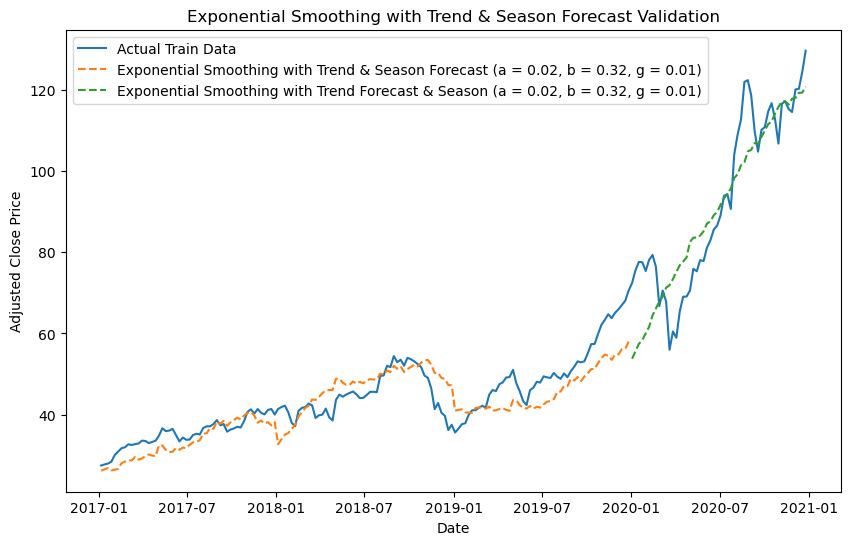

MAD: 7.84
MSE: 100.35


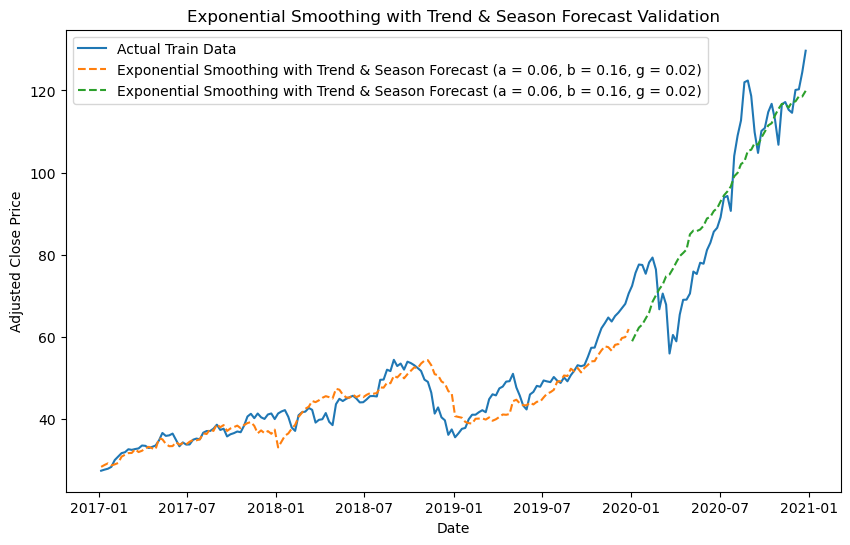

MAD: 7.99
MSE: 94.82


In [29]:
model = ExponentialSmoothing(train_train['Adj Close'], trend='add', seasonal='add', seasonal_periods=52)
result = model.fit(smoothing_level=0.02, smoothing_trend=0.32, smoothing_seasonal=0.01)
forecast = result.forecast(len(train_validation))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, result.fittedvalues, linestyle='--', label='Exponential Smoothing with Trend & Season Forecast (a = 0.02, b = 0.32, g = 0.01)')
plt.plot(train_validation.index, forecast, linestyle='--', label='Exponential Smoothing with Trend Forecast & Season (a = 0.02, b = 0.32, g = 0.01)')
plt.title('Exponential Smoothing with Trend & Season Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
mse = np.mean(np.square(train_validation['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

result = model.fit(smoothing_level=0.06, smoothing_trend=0.16, smoothing_seasonal=0.02)
forecast = result.forecast(len(train_validation))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, result.fittedvalues, linestyle='--', label='Exponential Smoothing with Trend & Season Forecast (a = 0.06, b = 0.16, g = 0.02)')
plt.plot(train_validation.index, forecast, linestyle='--', label='Exponential Smoothing with Trend & Season Forecast (a = 0.06, b = 0.16, g = 0.02)')
plt.title('Exponential Smoothing with Trend & Season Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
mse = np.mean(np.square(train_validation['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

### Seasonality Adjusted Exponential Smoothing Forecast for 5th Year

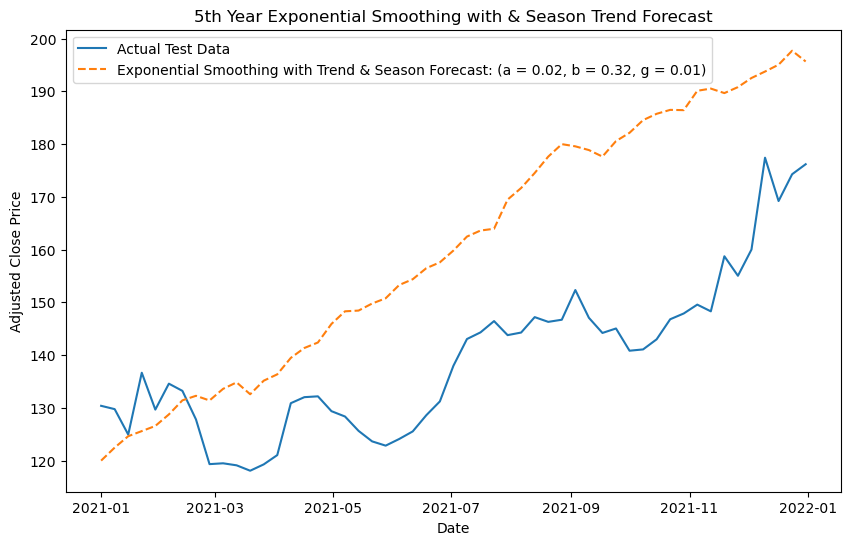

MAD: 22.82
MSE: 654.58


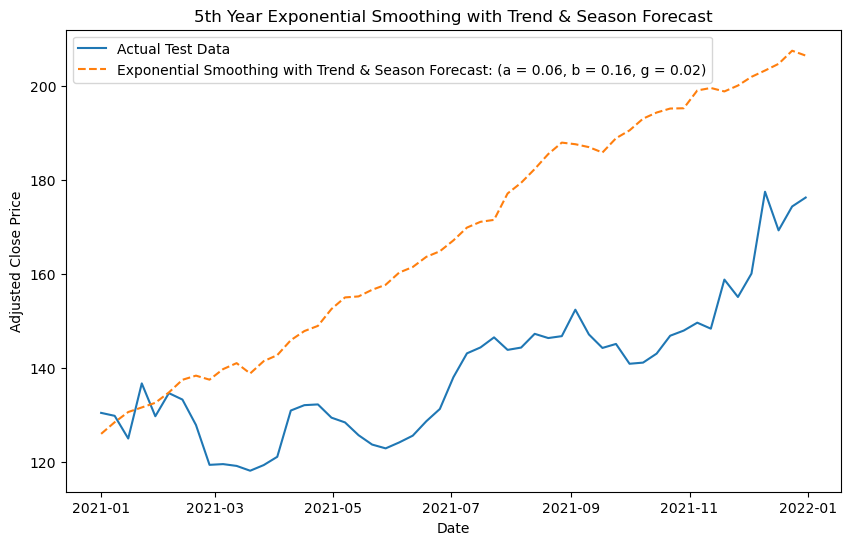

MAD: 29.16
MSE: 1052.66


In [22]:
model = ExponentialSmoothing(train['Adj Close'], trend='add', seasonal='add', seasonal_periods=52)
result = model.fit(smoothing_level=0.02, smoothing_trend=0.32, smoothing_seasonal=0.01)
forecast = result.forecast(len(test))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, forecast, linestyle='--', label='Exponential Smoothing with Trend & Season Forecast: (a = 0.02, b = 0.32, g = 0.01)')
plt.title('5th Year Exponential Smoothing with & Season Trend Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(test['Adj Close'] - forecast))
mse = np.mean(np.square(test['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

result = model.fit(smoothing_level=0.06, smoothing_trend=0.16, smoothing_seasonal=0.02)
forecast = result.forecast(len(test))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, forecast, linestyle='--', label='Exponential Smoothing with Trend & Season Forecast: (a = 0.06, b = 0.16, g = 0.02)')
plt.title('5th Year Exponential Smoothing with Trend & Season Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(test['Adj Close'] - forecast))
mse = np.mean(np.square(test['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

# C. Finally, choose a monthly data set (i.e. only 12 data points per year) from the first 4 years of your data at regular intervals. Then find at least another 10 similar data sets from other sources. For example, if your data set is the peak temperature of a municipality of a city on the 1st day of each month, find another 10 municipalities of the same city that you expect to have similar weather, and collect the corresponding data. Run your best forecasting technique over the 48 point data set to forecast the monthly data for year 5. Then adjust it taking advantage of the other 10 similar data sets and compare.

## Getting the stock price data and Separating into monthly

In [23]:
# Microsoft Corporation - MSFT
# Amazon.com, Inc. - AMZN
# Google (Alphabet Inc.) - GOOGL
# Facebook (Meta Platforms, Inc.) - META
# Tesla, Inc. - TSLA
# Berkshire Hathaway Inc. - BRK-B
# Johnson & Johnson - JNJ
# JPMorgan Chase & Co. - JPM
# Visa Inc. - V
# Coca-Cola - KO
 
ticker_symbols = ['MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-B', 'JNJ', 'JPM', 'V','KO']
 
start_time = '2017-01-01'
end_time = '2020-12-31'
 
# Create a dictionary to store dataframes
stock_dataframes = {}
 
for ticker in ticker_symbols:
    # Downloading stock data
    stock_data = yf.download(ticker, start=start_time, end=end_time)
    # Resample to monthly data and use the last available data of the month
    monthly_data = stock_data['Adj Close'].resample('M').last()
    # Store in the dictionary
    stock_dataframes[ticker] = monthly_data
 
# Download Apple's stock data
aapl_data = yf.download('AAPL', start=start_time, end='2021-12-31')
monthly_aapl_data = aapl_data['Adj Close'].resample('M').last()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Convert stock data to Dataframes

In [24]:
# Convert to DataFrame
frames = []
for symbol, series in stock_dataframes.items():
    frame = series.reset_index()
    frame['Symbol'] = symbol
    frames.append(frame)
 
result_df = pd.concat(frames)
 
# Rename columns for clarity
result_df.rename(columns={'index': 'Date', 'Adj Close': 'Adj Close'}, inplace=True)
result_df.set_index('Symbol', inplace=True)

# Conver Apple's stock data to DataFrame
aapl_df = pd.DataFrame(monthly_aapl_data)

print(result_df)
print(aapl_df)

             Date  Adj Close
Symbol                      
MSFT   2017-01-31  59.028755
MSFT   2017-02-28  58.771156
MSFT   2017-03-31  60.498096
MSFT   2017-04-30  62.886421
MSFT   2017-05-31  64.521797
...           ...        ...
KO     2020-08-31  44.498196
KO     2020-09-30  44.713486
KO     2020-10-31  43.527046
KO     2020-11-30  47.099590
KO     2020-12-31  49.691891

[480 rows x 2 columns]
             Adj Close
Date                  
2017-01-31   28.233545
2017-02-28   32.010571
2017-03-31   33.569149
2017-04-30   33.566814
2017-05-31   35.842892
2017-06-30   33.792179
2017-07-31   34.897316
2017-08-31   38.631306
2017-09-30   36.304012
2017-10-31   39.818512
2017-11-30   40.625942
2017-12-31   40.006573
2018-01-31   39.581047
2018-02-28   42.279884
2018-03-31   39.825497
2018-04-30   39.227345
2018-05-31   44.527885
2018-06-30   44.108521
2018-07-31   45.342819
2018-08-31   54.430515
2018-09-30   53.978588
2018-10-31   52.333447
2018-11-30   42.850758
2018-12-31   37.850140
2

## Compute A/F Ratio Mean for 4th Year Last Day

In [25]:
af_df = pd.DataFrame(columns=['Symbol', 'Adj Close', 'Naive', 'A/F'])

for i in ticker_symbols:
    new_row = pd.DataFrame({'Symbol': [i], 'Adj Close': [result_df.loc[i]['Adj Close'][47]], 'Naive': [result_df.loc[i]['Adj Close'][46]], 'A/F': [result_df.loc[i]['Adj Close'][47]/result_df.loc[i]['Adj Close'][46]]})
    af_df = pd.concat([af_df, new_row], ignore_index=True)
    
af_mean = af_df['A/F'].mean()

## AAPL Naive Forecast for 5th Year

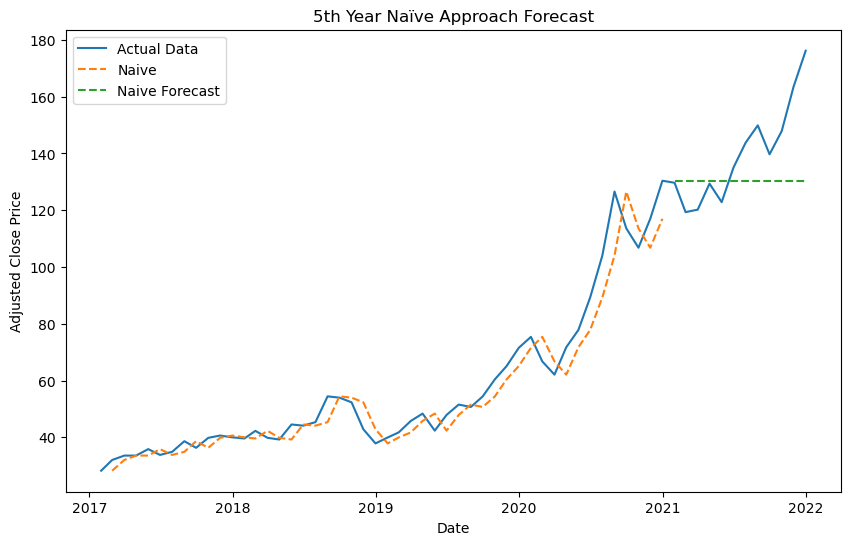

MAD: 14.48
MSE: 370.71


In [26]:
aapl_df['naive'] = naive(aapl_df['Adj Close'][:48], 12)

plt.figure(figsize=(10, 6))
plt.plot(aapl_df.index, aapl_df['Adj Close'], label='Actual Data')
plt.plot(aapl_df.index[:48], aapl_df['naive'][:48], linestyle='--', label='Naive')
plt.plot(aapl_df.index[-12:], aapl_df['naive'][-12:], linestyle='--', label='Naive Forecast')
plt.title('5th Year Naïve Approach Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(aapl_df['Adj Close'][-12:] - aapl_df['naive'][-12:]))
mse = np.mean(np.square(aapl_df['Adj Close'][-12:] - aapl_df['naive'][-12:]))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

## AAPL A/F Adjusted Naive Forecast for 5th Year

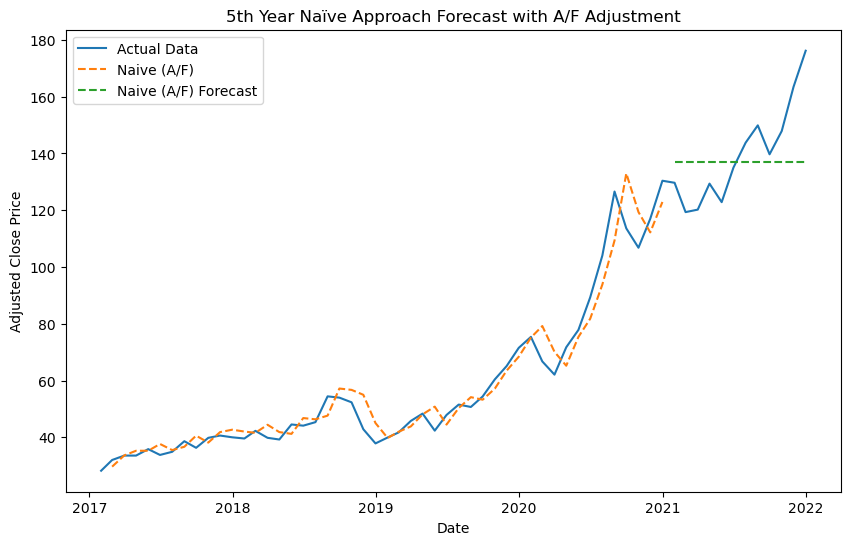

MAD: 13.70
MSE: 290.30


In [27]:
aapl_df['naive(a/f)'] = aapl_df['naive'] * af_mean

plt.figure(figsize=(10, 6))
plt.plot(aapl_df.index, aapl_df['Adj Close'], label='Actual Data')
plt.plot(aapl_df.index[:48], aapl_df['naive(a/f)'][:48], linestyle='--', label='Naive (A/F)')
plt.plot(aapl_df.index[-12:], aapl_df['naive(a/f)'][-12:], linestyle='--', label='Naive (A/F) Forecast')
plt.title('5th Year Naïve Approach Forecast with A/F Adjustment')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(aapl_df['Adj Close'][-12:] - aapl_df['naive(a/f)'][-12:]))
mse = np.mean(np.square(aapl_df['Adj Close'][-12:] - aapl_df['naive(a/f)'][-12:]))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

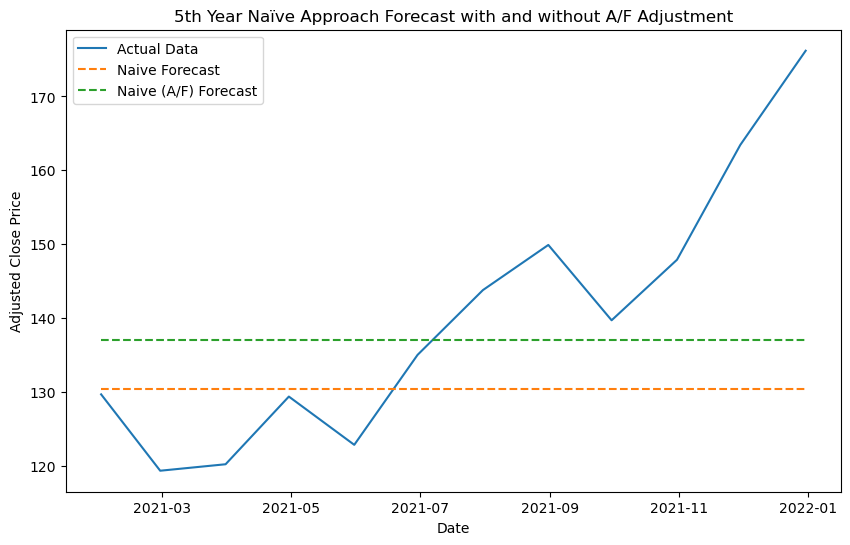

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(aapl_df.index[-12:], aapl_df['Adj Close'][-12:], label='Actual Data')
plt.plot(aapl_df.index[-12:], aapl_df['naive'][-12:], linestyle='--', label='Naive Forecast')
plt.plot(aapl_df.index[-12:], aapl_df['naive(a/f)'][-12:], linestyle='--', label='Naive (A/F) Forecast')
plt.title('5th Year Naïve Approach Forecast with and without A/F Adjustment')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()